# Trabajo práctico Aprendizaje de Máquina - *NASA Exoplanet Archive*
*Pablo Brahim - Kevin Pennington*

## Introducción al conjunto de datos KOI Q1–Q17 DR 25

El conjunto de datos utilizado en este trabajo corresponde a la **tabla de objetos de interés Kepler (Kepler Object-of-Interest - KOI) del Data Release 25 (DR 25)**, disponible públicamente en el [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/). Esta tabla contiene el resultado del análisis automatizado de curvas de luz obtenidas por el telescopio espacial **Kepler**, que tuvo como objetivo principal la detección de exoplanetas mediante el método de tránsito.

Durante su misión, Kepler monitoreó de forma continua la luminosidad de más de 150,000 estrellas. Variaciones periódicas en el brillo de una estrella pueden indicar que un objeto (como un planeta) pasa frente a ella, generando una pequeña disminución en la intensidad observada. Estas señales, conocidas como **eventos de cruce de umbral** (*Threshold Crossing Events*, o TCEs), son clasificadas y evaluadas en busca de patrones consistentes con un tránsito planetario.

En el DR 25, el análisis se realizó de forma completamente automatizada mediante un sistema denominado **Robovetter**, que aplica una serie de pruebas y métricas para determinar si una señal es **similar a un tránsito** (*transit-like*) o no. Aquellas consideradas transit-like reciben un número KOI y son sometidas a pruebas adicionales para descartar falsas detecciones, como eclipses estelares, errores instrumentales o señales contaminadas por objetos cercanos.

Cada KOI es finalmente etiquetado con una **disposición** (*disposition*), que puede ser:
- **PC** (*Planet Candidate*): candidato a planeta.
- **FP** (*False Positive*): falso positivo.
- (implícitamente) **Not transit-like**: señales que no fueron promovidas a KOI por no parecerse a un tránsito.

Adicionalmente, se incluye un parámetro llamado **Disposition Score**, un valor entre 0 y 1 que refleja el nivel de confianza del sistema en la disposición asignada. Valores cercanos a 1 indican alta confianza en que se trata de un planeta candidato, mientras que valores cercanos a 0 reflejan alta confianza en que es un falso positivo.

Es importante destacar que este catálogo fue construido con fines estadísticos y de uniformidad para estudios de tasa de ocurrencia planetaria. Por ello, algunas disposiciones pueden diferir de catálogos anteriores más conservadores, priorizándose en este caso la **confiabilidad global del conjunto por sobre la revisión manual individual de cada sistema**.

Este dataset incluye parámetros orbitales, características de la curva de luz, y propiedades estimadas de la estrella anfitriona y del posible planeta, calculados principalmente mediante métodos de ajuste como el muestreo Monte Carlo de cadenas de Markov (MCMC).


In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("./dr25.tab", sep="\t", header=53)
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,11446443,K00001.01,Kepler-1 b,CONFIRMED,CANDIDATE,0.811,0,0,0,0,...,-78.0,4.457,0.024,-0.024,0.964,0.038,-0.038,286.80847,49.316399,11.338
1,10666592,K00002.01,Kepler-2 b,CONFIRMED,CANDIDATE,1.000,0,1,0,0,...,-89.0,4.019,0.033,-0.027,1.952,0.099,-0.110,292.24728,47.969521,10.463
2,10748390,K00003.01,Kepler-3 b,CONFIRMED,CANDIDATE,0.913,0,0,0,0,...,-95.0,4.591,0.015,-0.036,0.763,0.028,-0.028,297.70935,48.080853,9.174
3,3861595,K00004.01,Kepler-1658 b,CONFIRMED,CANDIDATE,1.000,0,1,0,0,...,-114.0,3.657,0.270,-0.090,2.992,0.416,-0.971,294.35654,38.947380,11.432
4,8554498,K00005.01,NaN,CANDIDATE,CANDIDATE,1.000,0,0,0,0,...,-65.0,4.012,0.030,-0.030,1.787,0.132,-0.076,289.73972,44.647419,11.665


## Planteo del problema

En este trabajo vamos a plantear un problema de clasidicacion binaria: dados los atributos del KOI, buscamos predecir si se trata
de un candidato `CONFIRMED` o un `FALSE POSITIVE`.  En este aspecto destacan dos columnas `koi_disposition` y `koi_pdisposition`. 
En la [documentación](https://exoplanetarchive.ipac.caltech.edu/applications/DocSet/index.html?doctree=/docs/docmenu.xml&startdoc=item_1_01) puede hallarse un detalle de cada columna.

La columna `koi_pdisposition` se trata de la disposicion

    "The pipeline flag that designates the most probable physical explanation of the KOI."
la fuente de esta clasificacion es automaticamente asignada por el Kepler pipeline, basado en alguna pruebas internas.

Mientras que `koi_disposition` 
        
    "The category of this KOI from the Exoplanet Archive."
es el veredicto final de *NASA Exoplanet Archive*, que incluye revisiones manuales y estudios posteriores.
Representa la verdad autoritativa sobre el *label*. Esta categoria suele cambiar con el tiempo y los estudios.

Por tal motivo, el valor que buscamos predecir es el de la *disposición final* del *KOI*: `koi_disposition`

## Analisis de datos etc

Comenzamos por analizar la variable *target*, vemos que toma tres valores en este dataset:
`FALSE POSITIVE`, `CONFIRMED` y `CANDIDATE`.
No buscamos clasificar a `CANDIDATE` y, dada la naturaleza ambigua de este valor (se trata de objetos que aun no tienen veredicto final), es posible que sea necesario eliminar esas filas.

In [64]:
df.koi_pdisposition.value_counts()

koi_pdisposition
CANDIDATE         4034
FALSE POSITIVE    4020
Name: count, dtype: int64

Dado que existe un gran numero de `CANDIDATE`s seria bueno intentar inputar algunos casos con los labels a predecir,
para intentar no dañar mucho el dataset.

Existe una variable `koi_score` que expresa la confianza en la clasificacion en el pipeline:
        
    A value between 0 and 1 that indicates the confidence in the KOI disposition. 
    For CANDIDATEs, a higher value indicates more confidence in its disposition, 
    while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition.

Esto no es una regla rigida, por lo que simplemente clasificar todos los `CANDIDATE` con puntaje alto a `CONFIRMED` y los `FALSE POSITIVE` de puntaje alto como `FALSE POSITIVE` puede ser contra producente.

Además podemos mirar como se relaciona la variable `koi_pdisposition` con el target

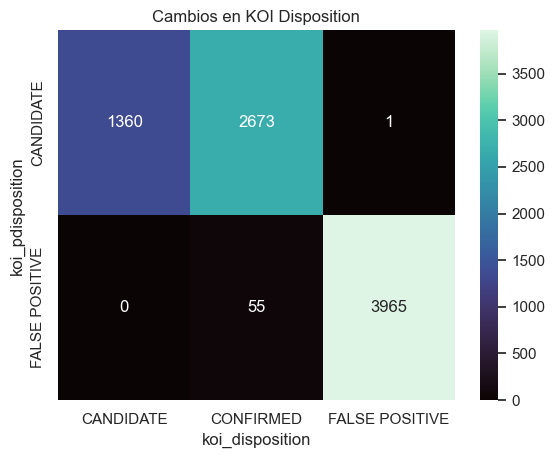

In [104]:
disposition_counts = pd.crosstab(
    df['koi_pdisposition'], 
    df['koi_disposition'],
    margins=True,
    margins_name="Total"
)
sns.heatmap(
    pd.crosstab(df['koi_pdisposition'], df['koi_disposition']),
    annot=True, fmt='d', cmap='mako'
)
plt.title("Cambios en KOI Disposition")
plt.show()


Algunas conclusiones pueden sacarse en base a esta relacion: 
    
* Es muy poco probable que un `FALSE POSITIVE` pase a confirmado `55/4020`
* o, equivalentemente, los casos `CONFIRMED` en la disposición final provienen de `CANDIDATOS` de la pipeline.
* reciprocamente, es extremadamente poco probable (1 solo caso) que un candidato de la pipeline, resulte `FALSO POSITIVO` (caveat: de aquellos que cambiaron de estado)

Podemos tomar esto para la inputacion de los `CANDIDATE` en el target, si además nos valemos del `koi_score`.
Podemos promover `CANDIDATE` a `CONFIRMED` cuando superen cierto umbral del score.

Miramos la distribucion `koi_score`

<Axes: xlabel='koi_score', ylabel='Count'>

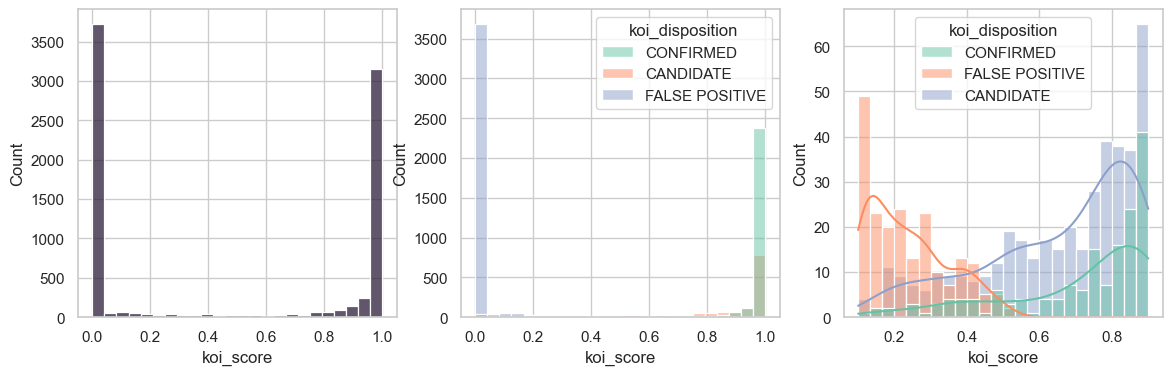

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.histplot(data=df, x='koi_score', bins=24, ax=axes[0])
sns.histplot(data=df, x='koi_score', bins=24, hue='koi_disposition', ax=axes[1], palette='Set2')
sns.histplot(
    data=df[(df["koi_score"] > 0.1) & (df["koi_score"] < 0.9)], 
    x='koi_score', 
    bins=24, 
    hue='koi_disposition', 
    ax=axes[2],
    palette='Set2',
    kde=True
)

En el ultimo histograma se muestra la distribucion del score, separada por la disposición final otrogada al KOI.
Los `FALSE POSITIVE` provienen generalmente de la parte inferior de la distribución.
Los `CONFIRMED` en su mayoría eran candidatos con alto score.
La distribución para candidatos esta fuertemente sesgada hacia la derecha.
Esto no es nada nuevo, simplemente es una visualización de la **definición** del KOI score


La elección del umbral tiene dos implicaciones principalmente.
Un threshold muy bajo, aporta poco 'ruido' al label (casos que son flageados como confirmados que podrian no serlo),
pero quedan muchos casos sin imputar que deben ser removidos.
Un threshold más alto reenokaza mas casos pero puede flaguear falsos confirmados.
Esto es dificil definirlo *a priori*, y podía ser evaluado con el modelo, usando distintos threshold.
Por ahora, observamos si el umbral de confianza se ubica por encima de 0.99 la mayoria de los datos son imputados

<Axes: xlabel='label', ylabel='count'>

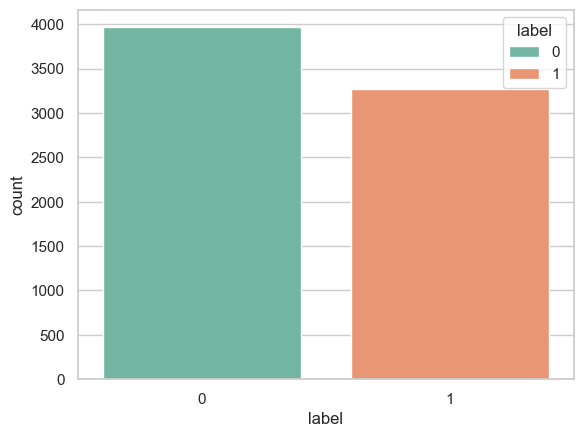

In [143]:
high_confidence_threshold = 0.99
label_map = {'CONFIRMED': 1, 'FALSE POSITIVE': 0}
df_binary = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
df_binary['label'] = df_binary['koi_disposition'].map(label_map)

candidates = df[df['koi_disposition'] == 'CANDIDATE'].copy()
pseudo_confirmed = candidates[candidates['koi_score'] >= high_confidence_threshold].copy()
pseudo_confirmed['label'] = 1

df_augmented = pd.concat([df_binary, pseudo_confirmed], ignore_index=True)
df_augmented.label.value_counts()
sns.countplot(data=df_augmented, x='label', hue='label', palette="Set2")

Como *bonus* se produce un balnceo de clases